In [1]:
%matplotlib widget  
  
import sympy as sym
import numpy as onp

from functools import partial

# from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from pdb import set_trace


In [2]:
def plot_3d(fnc,  x0, y0 = None, zlim = None):
    if y0 is None:
        y0 = x0
        
    x, y = onp.meshgrid(x0, y0); nx = len(x0); ny = len(y0)
    
    xy = onp.concatenate((x.reshape([1,nx*ny]),y.reshape([1,nx*ny])),axis=0)

    outputs = fnc(xy)
    z = outputs[0].reshape([ny,nx])

    fig = plt.figure()
    # plt.contour(x,y,z, 50, cmap='binary')
    ax = plt.axes(projection='3d')
#     ax.contour3D(x,y,np.sqrt(z), 50, cmap='binary')
    surf = ax.plot_surface(x,y,onp.sqrt(z), rstride=5, cstride=5, cmap=cm.hot,
                           linewidth=0, antialiased=False)

    # Customize the z axis.
    if zlim is not None:
        ax.set_zlim(zlim)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    ax.set_xlabel('x');ax.set_ylabel('y'); ax.set_zlabel('loss');

    plt.show()    

# loss functions

In [2]:
def shallownet_1d(w, a=1):
    f = a * w             # input-output map
    j = a                 # Jacobian of map
    err = f - 0           # target = 0
    loss = err ** 2 /2
    return loss, err, j 

def shallownet_2d(w, A = onp.array([[1,2],[2,1]]) ):
    f = A @ w             # input-output map
    j = A                 # Jacobian of map
    err = f - 0           # target = 0
    loss = (err ** 2 /2).sum(axis=0)
    return loss, err, j 

def deepnet_1d(w, d=1):
    f = w ** d              # input-output map
    j = d * w ** (d-1)      # Jacobian of map
    err = f - 1             # target = 1
    loss = err ** 2 /2
    return loss, err, j 

In [3]:
def landscape_simple(xy, py=onp):
#     x1,x2 = xy[0,:], xy[1,:]
    x1,x2 = xy[0], xy[1]

    y1 = x1 + py.sin(x2);    y2 = py.cos(x1) + x2 
    z1 = y1 * py.sin(y2);    z2 = py.cos(y1) * y2 
    
    loss = z1 ** 2 + z2 ** 2 
    return loss, None, None
    
def landscape_simple2(xy, py=onp):
    x1,x2 = xy[0,:], xy[1,:]

    y1 = x1 + py.sin(x2);    y2 = py.cos(x1) + x2 
    z1 = y1 * py.sin(y2) + py.cos(y1) * y2; 
    z2 = py.sin(y1) * y2 + y1 * py.cos(y2) 
    
    loss = z1 ** 2 + z2 ** 2 
    return loss, None, None


In [45]:
def landscape_loss(xy, freq = None, amp = None, py = np):
    err, Jacobian = landscape(xy, freq = None, amp = None, py = py)
    loss = (err ** 2).sum(axis=0)/2
    return loss,

def landscape(xy, freq = None, amp = None, py = onp):
    
    if freq is None:
        n = 4
        freq = onp.exp(onp.linspace(-2,1,n))  
        amp = 1/freq 

    err, Jacobian = landscape_core(xy, freq, amp, py)  #xy[0,:], xy[1,:]

    err = sym.Array(err) if py == sym else py.array(err)  
        
    return err, Jacobian

def landscape_core(x, freq, a, py):
    array = sym.Matrix if  py == sym else py.array
    
    def layer1(xs):
        x1,x2 = xs
        y1, y2 = x1 + 0, x2 + 0     #  y1, y2 = x1.copy(), x2.copy()
        
        dy1, dy2 = [1, 0], [0, 1]
        for i in range(len(freq)):
            y1 += a[i]* py.sin(freq[i]*x2) ;                  y2 += a[i]* py.cos(freq[i]*x1) 
            
            # derivatives 
            dy1[1] += a[i]*freq[i]* py.cos(freq[i]*x2) ;      dy2[0] += a[i]*freq[i]* -py.sin(freq[i]*x1) 
        return (y1, y2), array([dy1, dy2])

    def layer2(ys):
        y1,y2 = ys
        c1,  s1,  c2,  s2  = 0, 0, 0, 0 
        dc1, ds1, dc2, ds2 = [0, 0], [0, 0], [0, 0], [0, 0]
        for i in range(len(freq)):
            s1 += a[i]* py.sin(freq[i]*y1) ;                 c1 += a[i]* py.cos(freq[i]*y1) 
            s2 += a[i]* py.sin(freq[i]*y2) ;                 c2 += a[i]* py.cos(freq[i]*y2) 
            
            # derivatives 
            ds1[0] += a[i]*freq[i]* py.cos(freq[i]*y1) ;        dc1[0] += a[i]*freq[i]* -py.sin(freq[i]*y1) 
            ds2[1] += a[i]*freq[i]* py.cos(freq[i]*y2) ;        dc2[1] += a[i]*freq[i]* -py.sin(freq[i]*y2) 
        return (s1, s2, c1, c2), array([ds1, ds2, dc1, dc2])
    
    def layer3(ys, sc):
        y1,y2 = ys;        
        s1, s2, c1, c2 = sc
        z1     = y1 * s2 + c1 * y2;   z2     = s1 * y2 + y1 * c2 
        
        # derivatives 
        z1_dy  = [s2, c1];            z2_dy  = [c2, s1]; 
        z1_dsc = [ 0, y1, y2, 0];     z2_dsc = [y2, 0, 0, y1]
        return array((z1, z2)), array([z1_dy, z2_dy]), array([z1_dsc, z2_dsc])

    y,  y_x          = layer1(x)
    sc, sc_y         = layer2(y)
    z,  z_y, z_sc   = layer3(y, sc)
    
    output = z

    if len(x.shape) == 1:
        # Backprop for Jacobian
        out_y = z_sc @ sc_y + z_y
        out_x = out_y @ y_x        
        Jacobian = out_x
    else:
        Jacobian = None
    return output, Jacobian


#  Jacobian numerical check (using jax autodiff)

In [47]:
import jax.numpy as np
from jax import jacfwd, jacrev, random, grad

xy = onp.random.randn(2) 

err, j = landscape(xy, freq = None, amp = None, py = np)
print("My Jacobian", j)
print("My grad", err @ j)

f = lambda xy: landscape(xy, py=np)[0]
loss_fnc = lambda xy: landscape_loss(xy)[0]
grad_fnc = grad(loss_fnc)

j_Jax = jacfwd(f)(xy)  # Jacobian compute
print("Jax Jacobian", j_Jax)
print("Jax grad", grad_fnc(xy))


My Jacobian [[-13.725458 -20.706112]
 [ 14.051364  71.9647  ]]
My grad [-786.6601   951.08215]
Jax Jacobian [[-13.725458 -20.70611 ]
 [ 14.051365  71.9647  ]]
Jax grad [-786.6598  951.0834]


# Symbolic diff check... not sure...

In [ ]:
x1, x2 = sym.symbols('x1 x2');  xy = sym.Array([x1,x2])
a = sym.symbols('a1 a2')
freq = sym.symbols('f1 f2')

# print(xy.applyfunc(lambda x: x**2))   

out, j = landscape(xy, freq = freq, amp = a, py = sym)
print(j)
print(out.diff(xy))  # symbolic diff

# Plotting

In [39]:

x0 = onp.linspace(0,16, 401);
plot_3d(landscape_loss, x0) # zlim=[40,200])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

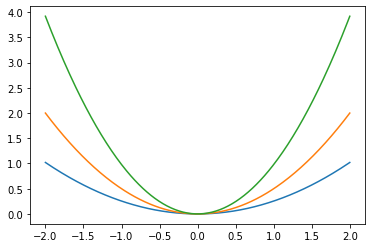

In [13]:
x = np.linspace(-2, 2, 301)
for a in [1/1.4, 1, 1.4]:
    y, _, _ = shallownet_1d(x, a)
    plt.plot(x, y)
    
plt.show()

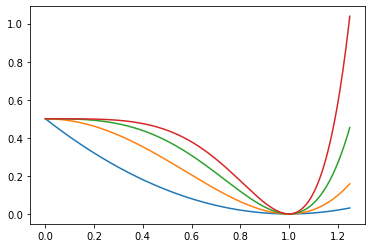

In [303]:
x = np.linspace(0, 1.25, 301)
for d in range(1,5):
    y, _, _ = deepnet_1d(x, d)
    plt.plot(x, y)
    
plt.show()

In [7]:
nx = 101;  x0 = np.linspace(-2, 2, nx)
plot_3d(shallownet_2d, x0)

fnc = partial(shallownet_2d,  A=np.array([[-1,2],[2,-1]]) )
plot_3d(fnc, x0)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [8]:
# x0 = np.linspace(-2,5, 201)
# plot_3d(landscape_simple, x0)

# x0 = np.linspace(-4,10, 201)
# plot_3d(landscape_simple2, x0)

x0 = np.linspace(0,20, 301); #y0 = np.linspace(-20, 0, 201);
plot_3d(landscape, x0)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

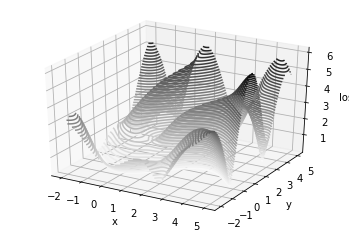

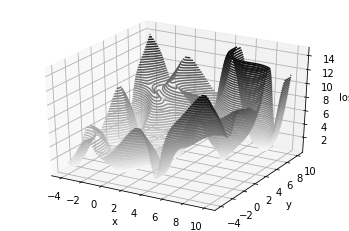

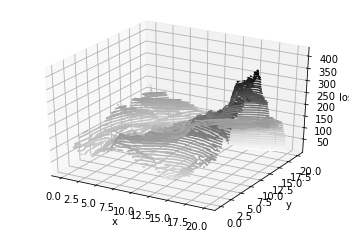

In [33]:
x0 = np.linspace(-2,5, 201)
plot_3d(landscape_2d_simple, x0, x0)

x0 = np.linspace(-4,10, 201)
plot_3d(landscape_2d_simple2, x0, x0)

x0 = np.linspace(0,20, 301); #y0 = np.linspace(-20, 0, 201);
plot_3d(landscape_2d, x0, x0)